$$\newcommand{\ket}[1]{\left|{#1}\right\rangle}$$
$$\newcommand{\bra}[1]{\left\langle{#1}\right|}$$
$$\newcommand{\braket}[2]{\left\langle{#1}\middle|{#2}\right\rangle}$$

<!DOCTYPE html>
<html>
<head>
<meta charset="UTF-8">
</head>
<body>
    
    
<div style="font-family:Georgia" align="center">
<h1 align="center">Quantum mechanics - Computation activities</h1>
<h1 align="center"><span style="text-decoration: gray underline overline" > Wave packet propagation</span></h1>
    
<br>
<br>
<br>
    
<h3> By: </h3>
<h3> Maxime Legrand </h3>
<h3> Chiari Even </h3>
    
<br>
<br>
<br>
    
<h3> Supervisor :</h3>
<h3> David Viennot </h3>
    
<br>
<br>
<br>

<h4> $5^{th}$ november 2022 <h4> 

    
    
</div>
</body> 
</html>

<h1 style="font-family:Georgia;text-decoration:gray underline">Introduction :</h1>




<h1 style="font-family:Georgia;text-decoration:gray underline">Requirements and limits :</h1>

In [2]:
import numpy as np
from numpy import linalg as LA
from scipy import linalg as LA2
import matplotlib.pyplot as py
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d as mp3d

plt.rcParams['figure.figsize'] = 8,5
plt.rcParams['figure.dpi'] = 150

<h1 style="font-family:Georgia;text-decoration:gray underline">Construction of the different used objects :</h1>
<h2 style="font-family:Georgia;text-decoration:gray"> Parameters :</h2>

In [3]:
# Toggle the potential 
# 1: wave packet in a box
# 2: in front of a potential barrier
# 3: Quantum Fermi accelerator
POT=1

# Space discretization
X_MAX=10
N_STEP=1000
DELTA_X=X_MAX/N_STEP

# Space axis
XD=[i*DELTA_X for i in range(N_STEP)]

# Time discretization
T_MAX=16
N_TIME=3000
DELTA_T=T_MAX/N_TIME

# Time axis
XT=[i*DELTA_T for i in range(N_TIME)]

# Particle mass
M=1

# Initial wave number
K0=0.05*np.sqrt(6)

# STD of gaussian packet
SIGMA_X=0.5

# Potential period
TAU=0.5

# Wave packet period
p=1


<h2 style="font-family:Georgia;text-decoration:gray"> Wave function :</h2>

In [4]:
def Psi(POT):
    """Returns the wave function object to be filled with respect
    to a chosen system and to N_STEP/N_TIME.

    Args:
        POT (int): input system

    Returns:
        2D array: Psi, initial values of the wave function
    """
    
    PSI=np.zeros((N_STEP,N_TIME),dtype="complex")

    # Box
    if POT == 1 :
        # Exponential prefactor
        C=1/np.sqrt(SIGMA_X*np.sqrt(2*np.pi)) 
        
        for i in range(N_STEP):
            PSI[i,0]=C*np.exp(-(XD[i]-X_MAX/2)**2/(4*SIGMA_X**2))
            
    # Barrier
    elif POT == 2:
        # Exponential prefactor
        C=1/np.sqrt(SIGMA_X*np.sqrt(2*np.pi)) 
        
        for i in range(N_STEP):
            PSI[i,0]=C*np.exp(-(XD[i]-10/2)**2/(4*SIGMA_X**2))*np.exp(1j*K0*XD[i])
    
    # Quantum Fermi accelerator
    elif POT == 3:
        # Exponential prefactor
        C=np.sqrt(2/X_MAX)
        
        for i in range(N_STEP):
            PSI[i,0]=C*np.sin(p*np.pi*XD[i]/X_MAX)

    else:
        return 'Please choose a valid system (1-3)'
            
    return PSI

<h2 style="font-family:Georgia;text-decoration:gray"> Potential :</h2>

In [5]:
def V(x,POT,t=0):
    """Potential value in a given point

    Args:
        x (float): space coordinate
        POT (int): selected system
        t (float, optional): Time dependency. Defaults to 0.

    Returns:
        float: Potential at given space and time point if time dependent
    """
    
    # Box
    if POT == 1:
        return 0
    
    # Barrier
    elif POT == 2:
        x0=10
        x1=11
        if x0 < x < x1:
            v=3
        else:
            v=0
        
        return v

    # Fermi accelerator
    elif POT == 3:
        X_MIN=0.75*X_MAX
        w=2*np.pi/TAU
        born=X_MAX-((X_MAX-X_MIN)/2)*(1-np.cos(w*t))
        
        if x < born :
            return 0
        
        else:
            return 10**15

<h2 style="font-family:Georgia;text-decoration:gray"> Hamiltonian construction (in DVR basis)
 :</h2>

In [6]:
def Hamiltonian(V,POT):
    """Function building the selected system hamiltonian

    Args:
        V (float): Potential value in a given point
        POT (int): Selected system
    Returns:
        2D array: System hamiltonian
    """
    
    HK=np.zeros((N_STEP,N_STEP),dtype="complex")

    # Looping over space steps twice
    for i in range(N_STEP):
        
        for j in range(N_STEP):
            
            if i == j :
                HK[i,j]=np.pi**2*((N_STEP+1)**2+2)/(3*X_MAX**2*2*M)
                
            else:
                HK[i,j]=(-1)**(j-i)*2*np.pi**2/(X_MAX**2*np.sin((j-i)*np.pi/(N_STEP+1))**2*2*M)

    # Checking if system is time-dependant
    if POT == 3:
        return HK
    
    # If time independant
    else:
        # Diagonal potential matrix
        Vmat=np.diag([V(XD[j],POT) for j in range(N_STEP)])
        
        # Hamiltonian
        H=HK +Vmat
        return H

<h2 style="font-family:Georgia;text-decoration:gray"> Propagator :</h2>


In [7]:
#normalisation function form TP1
def Norm(vector):
    return(np.sqrt(np.dot(np.conjugate(vector),vector)))


def Propagator(Psi,H,POT,V):
    """Propagates H with respect to its time
    dependency

    Args:
        Psi (2D array): Wave function matrix to be computed
        H (2D array): System Hamiltonian
        POT (int): Selected system
        V (float): Potential value in a given point

    Returns:
        2D array: Spacetime computed wave function
    """
    norm = np.zeros(N_TIME,dtype = 'complex_')
    norm[0] = Norm(Psi[:,0])
    expH=LA2.expm(-1j*H*DELTA_T)
    
    # Looping over time steps
    for i in range(N_TIME-1):

        # Checking time dependency
        if POT == 3:
            expV=np.diag([np.exp(-1j*V(XD[j],POT,XT[i])*DELTA_T/2) for j in range(N_STEP)])
            expH=expV @ expH @ expV
            Psi[:,i+1]=np.dot(expH,Psi[:,i])
            
        else:
            Psi[:,i+1]=np.dot(expH,Psi[:,i])
        
        Psi[:,i] = Psi[:,i]/Norm(Psi[:,i+1]) #normalisation for time 0 until time N_TIME-1
    Psi[:,-1] = Psi[:,-1]/Norm(Psi[:,-1]) # normalisation for the last value
    return np.real((Psi* np.conjugate(Psi)))


<h1 style="font-family:Georgia;text-decoration:gray underline"> Wave packet in a box and quantum carpet :</h1>


0.9999999999999556


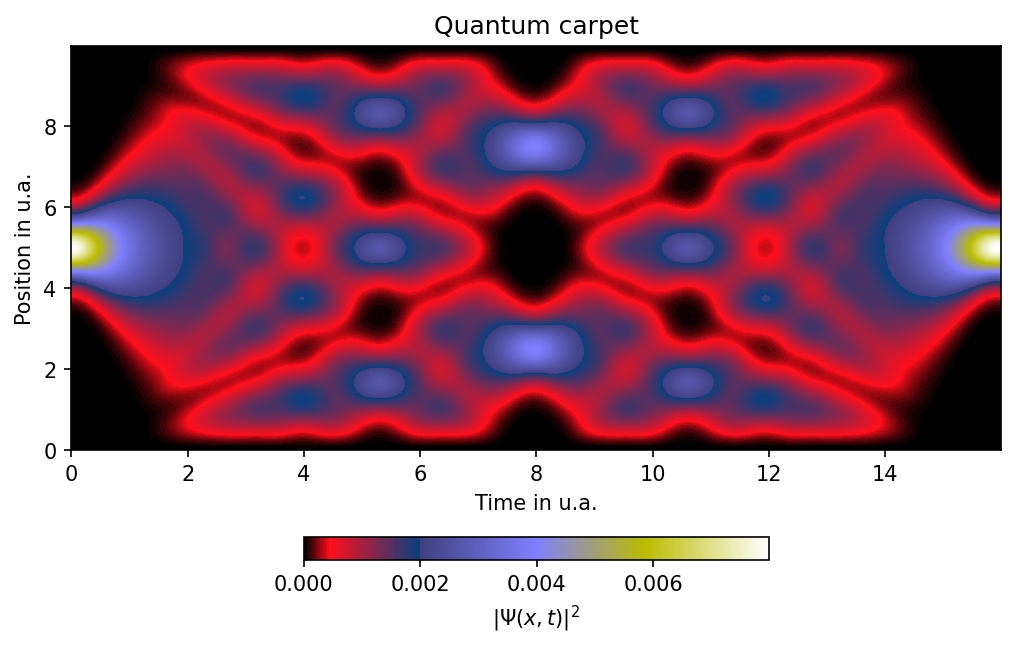

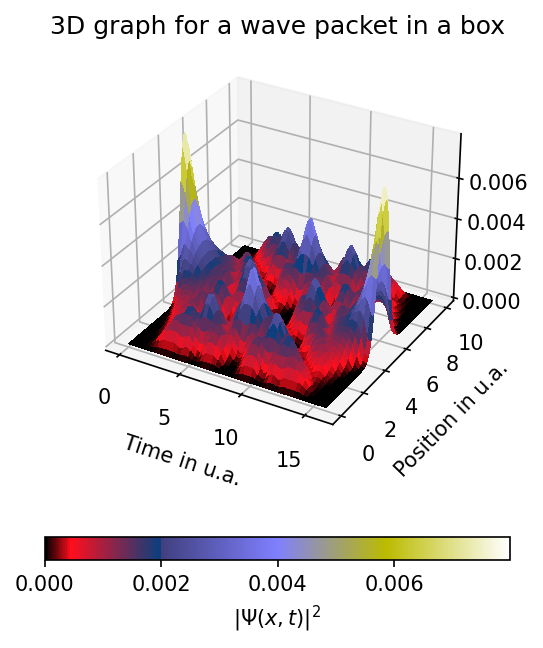

In [8]:

PSI=Psi(POT)

H=Hamiltonian(V,POT)

P=Propagator(PSI,H,POT,V)



print(sum(sum(P)/N_TIME))


plt.pcolormesh(XT,XD,P,cmap="gist_stern",shading='auto', vmin=0, vmax=np.max(P))
plt.colorbar(label=r'$|\Psi (x,t)|^{2}$',orientation='horizontal',shrink=0.5)
plt.xlabel("Time in u.a.")
plt.ylabel("Position in u.a.")
plt.title("Quantum carpet")
plt.show()


fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
X = XT
Y = XD
X, Y = np.meshgrid(X, Y)
Z = P

surf = ax.plot_surface(X, Y, Z, cmap="gist_stern",
                    linewidth=0, antialiased=False, vmin=0, vmax=np.max(P))
# Add a color bar which maps values to colors.
ax.set_xlabel("Time in u.a.")
ax.set_ylabel("Position in u.a.")
fig.colorbar(surf,label=r'$|\Psi (x,t)|^{2}$',orientation='horizontal',shrink=0.5)
plt.title("3D graph for a wave packet in a box")
plt.show()

<h1 style="font-family:Georgia;text-decoration:gray underline" >Wave packet in front of a potential barrier :</h1>

<h2 style="font-family:Georgia;text-decoration:gray"> Parameters :</h2>


In [9]:
POT=2
X_MAX=20
N_STEP=100
DELTA_X=X_MAX/N_STEP
XD=[i*DELTA_X for i in range(N_STEP)]
T_MAX=4
N_TIME=100
DELTA_T=T_MAX/N_TIME
XT=[i*DELTA_T for i in range(N_TIME)]
K0=0.01*np.sqrt(6)

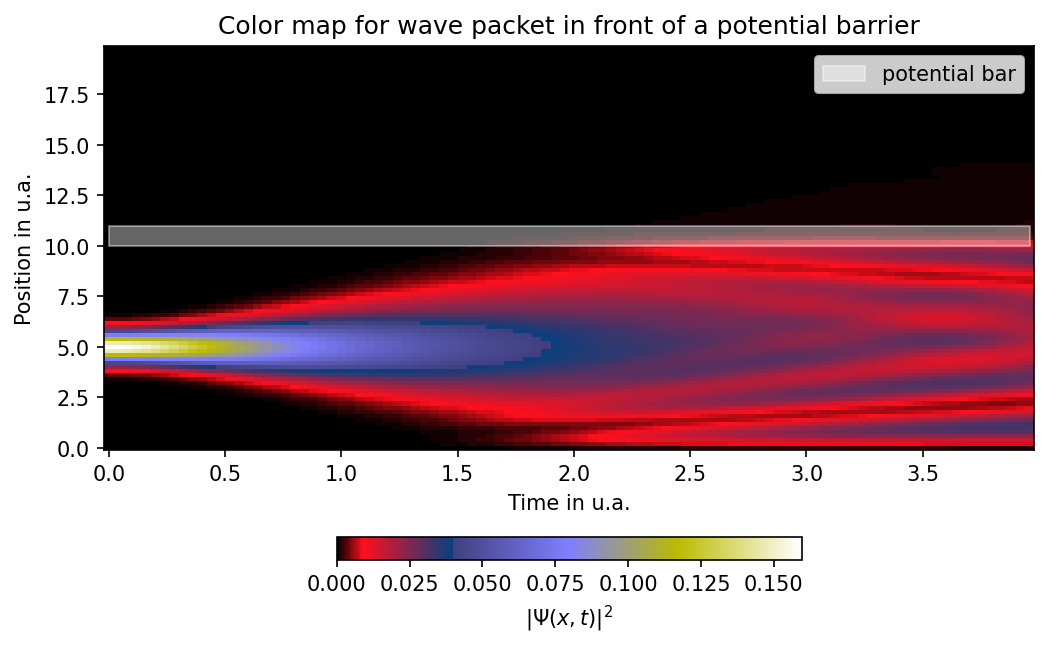

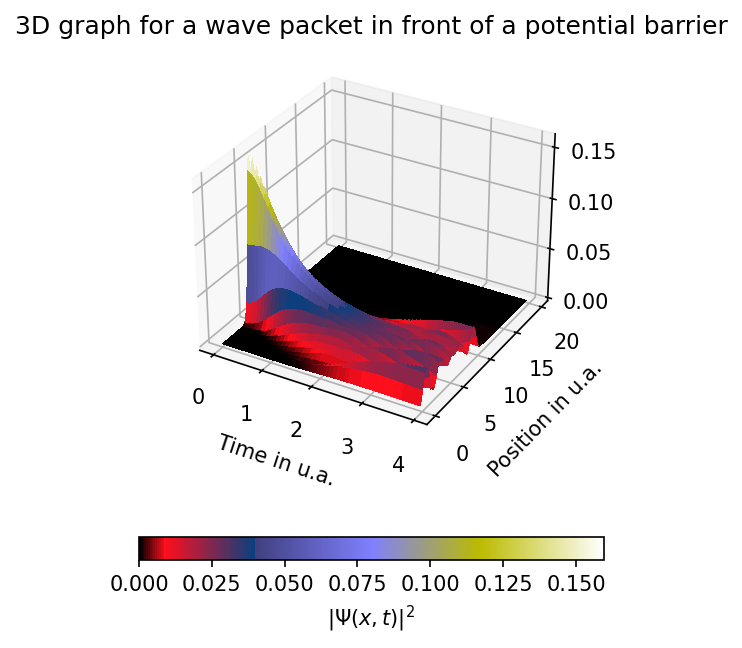

In [10]:

PSI=Psi(POT)

H=Hamiltonian(V,POT)

P=Propagator(PSI,H,POT,V)






plt.pcolormesh(XT,XD,P,cmap="gist_stern",shading='auto', vmin=0, vmax=np.max(P))
plt.colorbar(label=r'$|\Psi (x,t)|^{2}$',orientation='horizontal',shrink=0.5)
plt.xlabel("Time in u.a.")
plt.ylabel("Position in u.a.")
plt.fill_between(XT,[10]*N_TIME,y2 =[11]*N_TIME, alpha=0.4,color="white",label='potential bar')
plt.title("Color map for wave packet in front of a potential barrier")
plt.legend()
plt.show()


fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
X = XT
Y = XD
X, Y = np.meshgrid(X, Y)
Z = P

surf = ax.plot_surface(X, Y, Z, cmap="gist_stern",
                    linewidth=0, antialiased=False, vmin=0, vmax=np.max(P))
# Add a color bar which maps values to colors.
ax.set_xlabel("Time in u.a.")
ax.set_ylabel("Position in u.a.")
fig.colorbar(surf,label=r'$|\Psi (x,t)|^{2}$',orientation='horizontal',shrink=0.5)

plt.title("3D graph for a wave packet in front of a potential barrier")
plt.show()

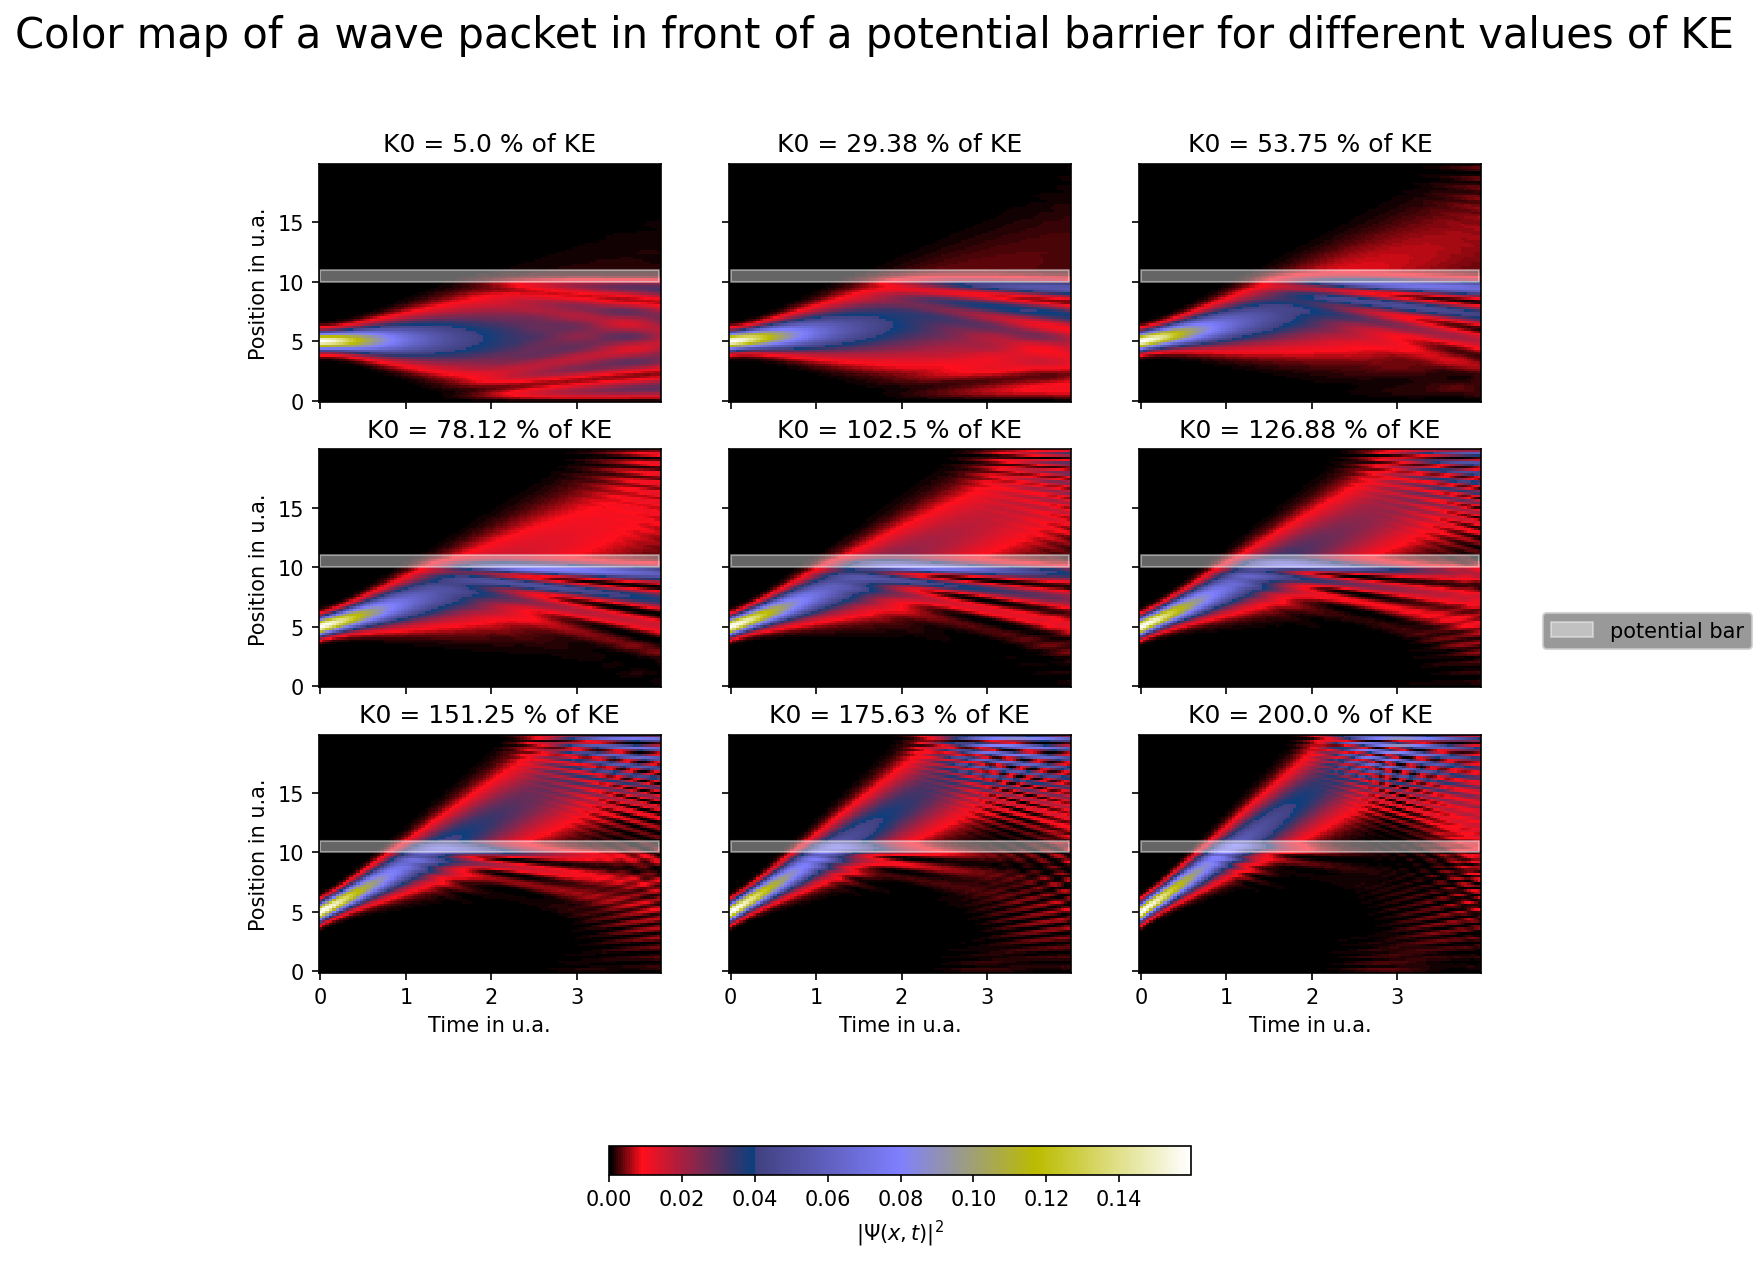

In [11]:
plt.rcParams['figure.figsize'] = 10,10
n =3
fig, axs = plt.subplots(n, n)

l_K0=[np.sqrt(2*M*3)*i for i in np.linspace(0.05,2,n**2)]

int=0
for ax in axs.flat:
    
    K0 = l_K0[int]
    PSI=Psi(POT)
    H=Hamiltonian(V,POT)
    P=Propagator(PSI,H,POT,V)

    im=ax.pcolormesh(XT,XD,P,cmap="gist_stern",shading='auto', vmin=0, vmax=np.max(P))
    ax.set(xlabel="Time in u.a.", ylabel="Position in u.a.")
    ax.set_title(f"K0 = {round(K0/np.sqrt(6)*100,2)} % of KE")
    
    int +=1
    if ax == axs[-1,-1]:
        ax.fill_between(XT,[10]*N_TIME,y2 =[11]*N_TIME, alpha=0.4,color="white",label='potential bar')
    else:
        ax.fill_between(XT,[10]*N_TIME,y2 =[11]*N_TIME, alpha=0.4,color="white")
   


# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()  
    
plt.suptitle("Color map of a wave packet in front of a potential barrier for different values of KE ",fontsize="20")
fig.legend(loc="center right",prop={"size" : 10},facecolor = "gray")    
fig.colorbar(im, ax=axs.ravel().tolist(),label=r'$|\Psi (x,t)|^{2}$',location="bottom",shrink=0.5)

plt.show()





<h1 style="font-family:Georgia;text-decoration:gray underline"> Quantum Fermi accelerator :</h1>

In [12]:
POT=3
X_MAX=20
M=1
N_STEP=100
DELTA_X=X_MAX/N_STEP
XD=[i*DELTA_X for i in range(N_STEP)]
T_MAX=30
N_TIME=400
DELTA_T=T_MAX/N_TIME
SIGMA_X=0.5
XT=[i*DELTA_T for i in range(N_TIME)]
TAU=24
p=2
plt.rcParams['figure.figsize'] = 5,5

In [13]:


PSI=Psi(POT)

H=Hamiltonian(V,POT)

P=Propagator(PSI,H,POT,V)






plt.pcolormesh(XT,XD,P,cmap="gist_stern",shading='auto', vmin=0, vmax=np.max(P))
plt.colorbar(label=r'$|\Psi (x,t)|^{2}$',orientation='horizontal',shrink=0.5)
plt.xlabel("Time in u.a.")
plt.ylabel("Position in u.a.")
potential=[X_MAX-((X_MAX-0.75*X_MAX)/2)*(1-float(np.cos((2*np.pi/TAU*i)))) for i in XT]
plt.fill_between(XT, potential,y2=[20]*N_TIME, alpha=0.4,color="white",label='potential bar')
plt.title("Color map for quantum Fermi accelerator")
plt.legend(facecolor = "gray",prop={"size" : 10})
plt.show()


fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
X = XT
Y = XD
X, Y = np.meshgrid(X, Y)
Z = P

surf = ax.plot_surface(X, Y, Z, cmap="gist_stern",
                    linewidth=0, antialiased=False, vmin=0, vmax=np.max(P))
# Add a color bar which maps values to colors.
ax.set_xlabel("Time in u.a.")
ax.set_ylabel("Position in u.a.")
fig.colorbar(surf,label=r'$|\Psi (x,t)|^{2}$',orientation='horizontal',shrink=0.5)
plt.title("3D graph for quantum Fermi accelerator")
plt.show()

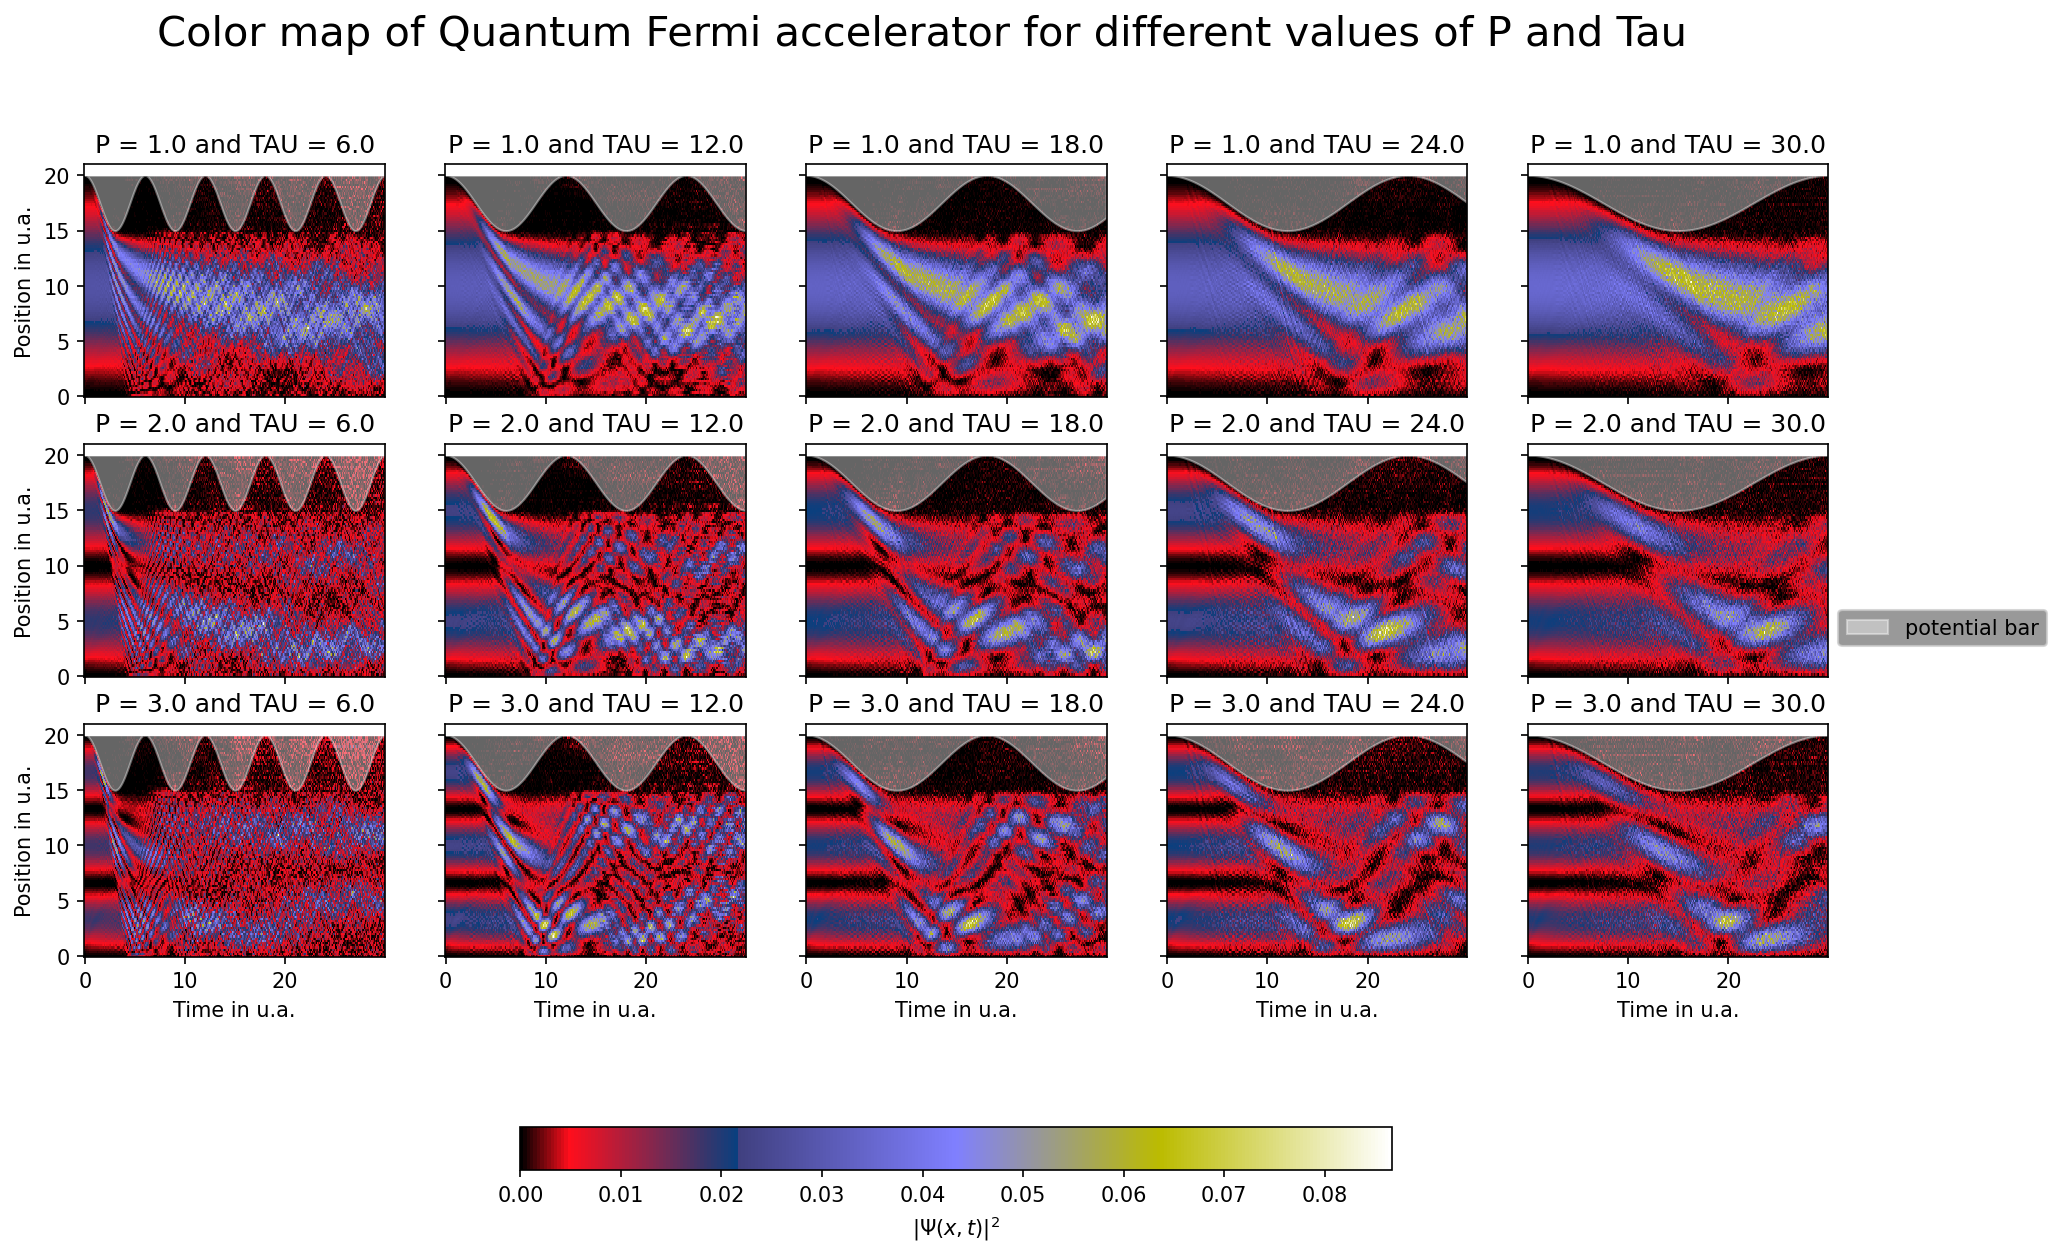

In [ ]:
plt.rcParams['figure.figsize'] = 15,10
n, m = 3 ,5
fig, axs = plt.subplots(n, m)



for ax in axs.flat:
    p=float(np.where(axs == ax)[0] +1)
    TAU=float((np.where(axs == ax)[1] +1)*30/m)
    PSI=Psi(POT)
    H=Hamiltonian(V,POT)
    P=Propagator(PSI,H,POT,V)
    im=ax.pcolormesh(XT,XD,P,cmap="gist_stern",shading='auto', vmin=0, vmax=np.max(P))
    ax.set(xlabel="Time in u.a.", ylabel="Position in u.a.")
    ax.set_title(f"P = {p} and TAU = {TAU}")
    potential=[X_MAX-((X_MAX-0.75*X_MAX)/2)*(1-float(np.cos((2*np.pi/TAU*i)))) for i in XT]
    if ax == axs[-1,-1]:
        ax.fill_between(XT, potential, y2=np.max(potential), alpha=0.4,color="white",label='potential bar')
    else:
        ax.fill_between(XT, potential, y2=np.max(potential), alpha=0.4,color="white")
    

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()  
plt.suptitle("Color map of Quantum Fermi accelerator for different values of P and Tau ",fontsize="20")   
fig.legend(loc="center right",prop={"size" : 10},facecolor = "gray")    
fig.colorbar(im, ax=axs.ravel().tolist(),label=r'$|\Psi (x,t)|^{2}$',location="bottom",shrink=0.5)
plt.show()


<h1 style="font-family:Georgia;text-decoration:gray underline"> Conclusion :</h1>